## Excercici
Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

Fent una inspeccó ocular de les dades identidiquem aquests camps:
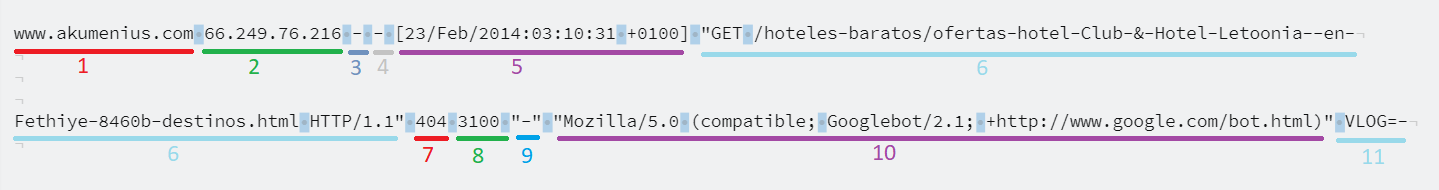

Ajudant-nos de [documentació de registres de logs](http://manuales.guebs.com/apache-2.0/logs.html) podem disgingir els següents camps:

- 1 URL
- 2 Client IP
- 3 Identitat RFC
- 4 Remote User
- 5 Datetime
- 6 Request Method: Mètode, Recurs, Protocol (entre " ")
- 7 Status Code
- 8 Response size
- 9 HTTP Referer (entre " ")
- 10 User-agent (entre " ") : Navegador/versió; bot; url-bot (separats per ;)
- 11 Info

In [1]:
#generem un pattern per tots els camps que hi conté, concatenant-los amb espais (tal i com ho fa al log)
sp = r" "
#camps
url = r'((\w+.)?\w+\.(com|es)|localhost)'
ip = r'((\d{1,3}\.){3}\d{1,3})'
rfc = r'([^ ]+)'
ruser = r'([^ ]+)'
#a datetime també ho podriem filtrar tb per '\[(.*?)\]' sense especificar el contingut
datetime = r'\[(\d{1,2}\/\w{3}\/\d{4}:\d{2}:\d{2}:\d{2} \+\d{4})\]'
request = r'"(.*?)"'
sc = r'(\d{2,5}|-)'
rsize = r'(\d+|-)'
referer = r'"(.*?)"'
user_agent = r'"(.*?)"'
info = r'(.*)'
camps = [url,ip,rfc,ruser,datetime,request,sc,rsize,referer,user_agent,info]
pattern = sp.join(camps)
pattern

'((\\w+.)?\\w+\\.(com|es)|localhost) ((\\d{1,3}\\.){3}\\d{1,3}) ([^ ]+) ([^ ]+) \\[(\\d{1,2}\\/\\w{3}\\/\\d{4}:\\d{2}:\\d{2}:\\d{2} \\+\\d{4})\\] "(.*?)" (\\d{2,5}|-) (\\d+|-) "(.*?)" "(.*?)" (.*)'

## Excercici
Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [2]:
import os
import pandas as pd
import numpy as np
import re

In [3]:
#importem el log en una columna per registre
pd.options.display.max_columns = None
datasets_path = r"D:\Oscar\FORMACIO\DIGITAL\DATA SCIENCE with Python\Datasets\Data-sources" + os.sep
file = "Web_access_log-akumenius.com.txt"

df = pd.read_csv(datasets_path + file, names=["LOG"], engine='python', sep='sense separador')
df.sample(2)

,LOG
204864,test.akumenius.com 80.28.221.123 - - [27/Feb/2...
1540,www.akumenius.com 162.243.192.191 - - [23/Feb/...


In [4]:
#amb el mètode extract, dels mètodes d'strings, amb la opció expands=True, treiem les columnes pels grups del match que
#obtindrem amb el pattern de regex creat
df = df["LOG"].str.extract(pattern, expand=True)

#eliminem les columnes dels subgrups que s'hauran generat al definir les repeticions dels regex
df.drop(labels=[1,2,4], axis=1, inplace=True)

#renombrem les columnes
rename = {0: "URL", 3: "IP", 5: "RFC", 6: "R_USER", 7: "TIME", 8: "REQUEST", 
          9: "SC", 10: "RES_SIZE", 11: "REFERER", 12: "USER-AGENT", 13: "INFO"}
df.rename(columns=rename, inplace=True)
df.head(3)

,URL,IP,RFC,R_USER,TIME,REQUEST,SC,RES_SIZE,REFERER,USER-AGENT,INFO
0,localhost,127.0.0.1,-,-,23/Feb/2014:03:10:31 +0100,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),VLOG=-
1,localhost,127.0.0.1,-,-,23/Feb/2014:03:10:31 +0100,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),VLOG=-
2,localhost,127.0.0.1,-,-,23/Feb/2014:03:10:31 +0100,OPTIONS * HTTP/1.0,200,-,-,Apache (internal dummy connection),VLOG=-


In [5]:
#comprovem que no hi hagin nulls
df.isnull().sum().sum()

0

In [6]:
#Podem classificar els registres pel tipus de resposta del state code (en funció del número amb el que comença)
state_codes = {"1": "Informational Response", "2": "Successful ", 
               "3": "Redirection ", "4": "Client Error", "5": "Server Error"}

#creem columna pel Tipus de Status Code
df["SC_TYPE"] = df["SC"].apply(lambda x: x[0]).map(state_codes)

#podem veure el recompte dels casos
df.SC_TYPE.value_counts()

Successful      226686
Redirection      26248
Client Error      8892
Server Error        47
Name: SC_TYPE, dtype: int64

In [7]:
#com els camps amb valors "-" són valors nulls podriem donals-hi aquest caràcter
df.replace("-", np.nan, inplace=True)

#donem també un format numèric als Status Code i RES_SIZE així com de datetime al de la columna temporal
df["SC"] = pd.to_numeric(df.SC, downcast='integer')
df["RES_SIZE"] = pd.to_numeric(df.RES_SIZE, downcast='integer')
df["TIME"] = pd.to_datetime(df.TIME, format="%d/%b/%Y:%H:%M:%S %z")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261873 entries, 0 to 261872
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype                               
---  ------      --------------   -----                               
 0   URL         261873 non-null  object                              
 1   IP          261873 non-null  object                              
 2   RFC         0 non-null       float64                             
 3   R_USER      27 non-null      object                              
 4   TIME        261873 non-null  datetime64[ns, pytz.FixedOffset(60)]
 5   REQUEST     261836 non-null  object                              
 6   SC          261873 non-null  int16                               
 7   RES_SIZE    219538 non-null  float64                             
 8   REFERER     162326 non-null  object                              
 9   USER-AGENT  261654 non-null  object                              
 10  INFO        261873 non-null  obj

In [8]:
#veiem que la columna RFC no ens aporta cap dada. La eliminem
df.drop(columns="RFC", inplace=True)

In [9]:
#Podriem extraure en una altra columna el mètode utilitzat pel request
pattern = r'(^GET|^POST|^HEAD)'
df["REQ_METHOD"] = df["REQUEST"].str.extract(pattern, expand=True)
df.sample(3)

,URL,IP,R_USER,TIME,REQUEST,SC,RES_SIZE,REFERER,USER-AGENT,INFO,SC_TYPE,REQ_METHOD
109613,www.akumenius.com,88.11.41.24,NaN,2014-02-25 14:58:52+01:00,GET /modules/raton/views/themes/bcoos/images/b...,200,8158.0,http://www.akumenius.com/?gclid=CNe7y-S357wCFe...,Mozilla/5.0 (Linux; U; Android 4.2.2; es-es; S...,VLOG=-,Successful,GET
141897,www.akumenius.com,85.137.214.209,NaN,2014-02-25 22:13:16+01:00,GET /libraries/jqueryui/css/ui-lightness/image...,200,4369.0,http://www.akumenius.com/hoteles-baratos/ofert...,Mozilla/5.0 (Linux; U; Android 4.2.2; es-es; G...,VLOG=-,Successful,GET
56080,www.akumenius.com,80.58.250.94,NaN,2014-02-24 12:10:17+01:00,GET /modules/raton/views/themes/bcoos/googleMa...,304,NaN,http://www.akumenius.com/hotel-list,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:27.0) G...,VLOG=-,Redirection,GET


## Exercici 
Geolocalitza les IP's.

*Primer categoritzarem de quin tipus son les IPs per fer la geolocalització únicament d'aquelles que siguin globals.*
*Utilitzarem la llibreria [ipaddress](https://docs.python.org/3/library/ipaddress.html#module-ipaddress) per identificarles*

In [10]:
import ipaddress

#testegem una ip local i ens retorna que no és global
ipaddress.ip_address("172.21.10.72").is_global

False

In [11]:
#generem la columna booleana GLOBAL que ens dirà si es tracta d'un accés extern (les locals no ens interessen)
df["GLOBAL"] = df.IP.apply(lambda x: ipaddress.ip_address(x).is_global)

In [12]:
#com al log les ip's ens apareixem per cada request, sortiran repetides molts cops
df[df["GLOBAL"] == True]["IP"].value_counts().head()

66.249.76.216      46382
80.28.221.123      14725
217.125.71.222      5201
66.249.75.148       3558
162.243.192.191     2927
Name: IP, dtype: int64

In [13]:
#busquem IPs úniques i creem un altre dataframe amb aquesta info (ips_df) perquè ens faci les peticions/consultes, 
#un cop per IP, i no gastar més quota de la necessària a les APIs que provarem
global_df = df[df["GLOBAL"]]
ips_df = pd.DataFrame(global_df['IP'].unique(), columns=["IP"])
del global_df
len(ips_df)

2920

### OPCIÓ 1
*Per obtenir la geolocalització utilitzarem el recurs API de geolocalització d'IPs a [Abstract API](https://app.abstractapi.com/dashboard)*

*Segons la web ens permeten 20.000 calls/month de quota gratuïta*

In [14]:
#provem amb la nostra ip
import requests
API_KEY = "324b61a2c48845d696fd52317bb61012"
API_URL = "https://ipgeolocation.abstractapi.com/v1/"
IP = "139.47.119.155"
api_request = "{}?api_key={}&ip_address={}".format(API_URL, API_KEY, IP)
response = requests.get(api_request)
print(response.status_code)
print(response.content)

200
b'{"ip_address":"139.47.119.155","city":"Barcelona","city_geoname_id":3128760,"region":"Catalonia","region_iso_code":"CT","region_geoname_id":3336901,"postal_code":"08024","country":"Spain","country_code":"ES","country_geoname_id":2510769,"country_is_eu":true,"continent":"Europe","continent_code":"EU","continent_geoname_id":6255148,"longitude":2.1701,"latitude":41.387,"security":{"is_vpn":false},"timezone":{"name":"Europe/Madrid","abbreviation":"CEST","gmt_offset":2,"current_time":"22:05:07","is_dst":true},"flag":{"emoji":"\xf0\x9f\x87\xaa\xf0\x9f\x87\xb8","unicode":"U+1F1EA U+1F1F8","png":"https://static.abstractapi.com/country-flags/ES_flag.png","svg":"https://static.abstractapi.com/country-flags/ES_flag.svg"},"currency":{"currency_name":"Euros","currency_code":"EUR"},"connection":{"autonomous_system_number":15704,"autonomous_system_organization":"Xtra Telecom S.A.","connection_type":"Corporate","isp_name":"Xtra Telecom S.A.","organization_name":"MasMovil - Spain"}}'


In [15]:
#iterarem el dataframe de IPs per obtinde amb una petició la informació de totes les columnes que hi agregarem
keys = ["city", "region", "country", "continent", "longitude", "latitude"]

for i in ips_df.index:
    ip = ips_df.IP[i]
    api_request = "{0}?api_key={1}&ip_address={2}".format(API_URL, API_KEY, ip)
    response = requests.get(api_request)
    for k in keys:
        ips_df.loc[i, k] = response.json()[k]

KeyError: 'city'

In [16]:
#no ens deixa fer més d'una petició per segon :( Hem de pagar per fer solicituds amb una frequència major
response.json()

{'error': {'message': 'Free plan is limited to 1 request per second. Please wait or upgrade to remove this restriction.',
  'code': 'too_many_requests',
  'details': None}}

In [17]:
#esborrem les columnes generades del primer request
ips_df = ips_df["IP"]
ips_df = pd.DataFrame(ips_df, columns=['IP'])

### OPCIÓ 2

*Provem amb el paquet [ip2geotools 0.1.5](https://pypi.org/project/ip2geotools/)

(no hem trobat les especificacions de quota)

In [22]:
import json

#si hi hagués excepció en el request agregarem null values a la resposta
keys = ["ip_address", "city", "region", "country", "latitude", "longitude"]
values = [np.nan] * 6
void_response = dict(zip(keys, values))

#iterarem el dataframe de IPs per obtinde de cada petició la informació de totes les columnes que hi agregarem
n=0
for i in ips_df.index:
    n += 1
    ip = ips_df.IP[i]
    try:
        response = DbIpCity.get(ip, api_key='free')
        response_dic = json.loads(response.to_json())
    except InvalidRequestError as ex:
        response_dic = void_response
        print(ip, ex)
    for key in response_dic.keys():
        ips_df.loc[i, key] = response_dic[key]

InvalidRequestError: 

In [26]:
#ens torna excepcions al cap d'una estona, 
ips_df

,IP,ip_address,city,region,country,latitude,longitude
0,66.249.76.216,66.249.76.216,Mountain View,California,US,37.389389,-122.083210
1,5.255.253.53,5.255.253.53,Moscow (Tsentralnyy administrativnyy okrug),Moscow,RU,NaN,NaN
2,157.55.35.112,157.55.35.112,Newark,New Jersey,US,40.735657,-74.172367
3,193.111.141.116,193.111.141.116,Amsterdam (Nieuwmarkt en Lastage),North Holland,NL,52.367431,4.901221
4,5.10.83.71,5.10.83.71,London,England,GB,51.507322,-0.127647
...,...,...,...,...,...,...,...
2915,46.222.83.180,NaN,NaN,NaN,NaN,NaN,NaN
2916,79.155.78.117,NaN,NaN,NaN,NaN,NaN,NaN
2917,217.174.248.179,NaN,NaN,NaN,NaN,NaN,NaN
2918,188.135.173.80,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
#mirem de fer una peticio manual
from ip2geotools.databases.noncommercial import DbIpCity
IP = "8.8.8.8"
response = DbIpCity.get(IP, api_key='free')
response.to_json()

InvalidRequestError: 

*Amb el **ip2geotools** ens passa una cosa semblant. Va retornant les requests, però al cap d'una estona d'estar en bucle ens comença a donar un **InvalidRequestError**.* 

*Segurament és una limitació de quota per solicituds doncs ens ha omplert quasi 1000 registres al dataframe (hem fet unes poques proves abans).*

*Podem pensar que la quota és de 1000 solicituds (possiblement per dia)*

In [28]:
#esborrem les columnes generades
ips_df = ips_df["IP"]
ips_df = pd.DataFrame(ips_df, columns=['IP'])

### OPCIÓ 3

Api de [ip-api](https://ip-api.com/)

Ens especifiquen unes quotes bastant més grans, sobretot per la possiblitat de multiconsulta de 100 IPs per request:

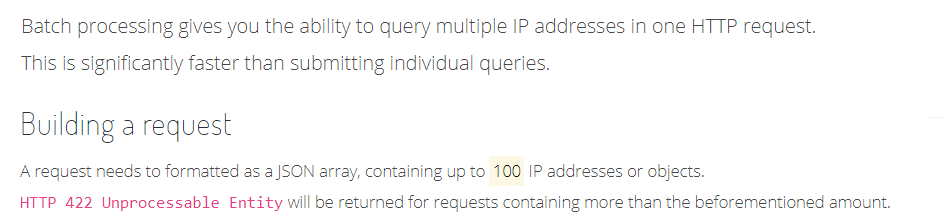
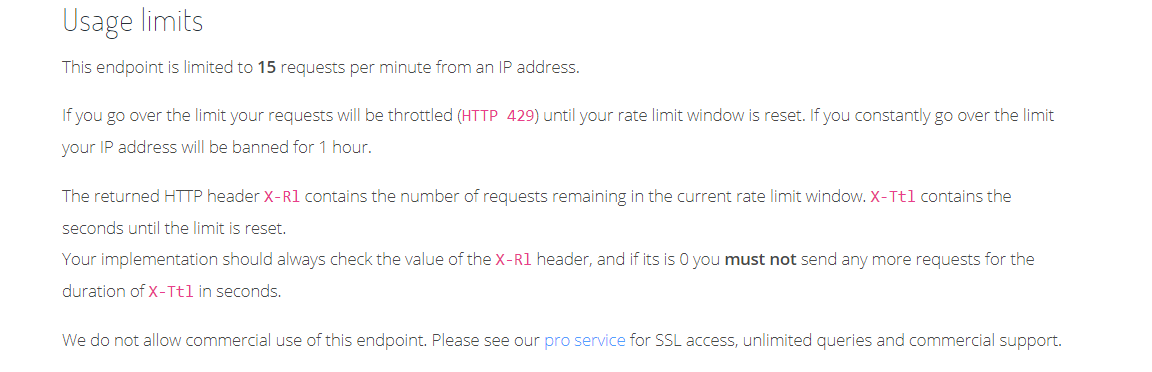

*Per salvar les limitacions de quota haurem d'implementar un codi que ens faci paquets de queries de 100 ips per request, i ens envïi 15 requests per minut. Si tenim en compte que així podem obtindre 1500 geolocalitzacions per minut, i tenim 2920 ips úniques per geolocalitzar, ho podem tenir tot en dos minuts*

In [30]:
import requests

#fem una prova de query multiple a ip-api on veiem que ens retorna una llista de diccionaris i tots els camps 
#d'informació de la geolocalització, a no ser que li especifiquem els que volem en concret
URL = "http://ip-api.com/batch"
query = [{'query': '208.80.152.201', 'fields': 'query,city,region,country,lat,lon', 'lang': 'en'},
         {'query': '8.8.8.8'},
         {'query': '139.47.119.155'}]
response = requests.post(URL, json=query)
response.json()

[{'country': 'United States',
  'region': 'IL',
  'city': 'Chicago',
  'lat': 41.8781,
  'lon': -87.6298,
  'query': '208.80.152.201'},
 {'status': 'success',
  'country': 'United States',
  'countryCode': 'US',
  'region': 'VA',
  'regionName': 'Virginia',
  'city': 'Ashburn',
  'zip': '20149',
  'lat': 39.03,
  'lon': -77.5,
  'timezone': 'America/New_York',
  'isp': 'Google LLC',
  'org': 'Google Public DNS',
  'as': 'AS15169 Google LLC',
  'query': '8.8.8.8'},
 {'status': 'success',
  'country': 'Spain',
  'countryCode': 'ES',
  'region': 'CT',
  'regionName': 'Catalonia',
  'city': 'Barcelona',
  'zip': '08003',
  'lat': 41.387,
  'lon': 2.1701,
  'timezone': 'Europe/Madrid',
  'isp': 'Xtra Telecom S.A.',
  'org': 'MasMovil - Spain',
  'as': 'AS15704 XTRA TELECOM S.A.',
  'query': '139.47.119.155'}]

In [31]:
#integrarem dos comptadors com a columnes al dataframe de les IPs úniques que volem consultar. Un comptador de 100 en 100 
#(pel màxim d'IPs per request) i l'altre de 1500 en 1500 (pel màxim de requests per minut)
#definim la funció que ho implementa
def genera_columnes_contadores(req_max_x_min, ips_max_x_req, df=ips_df):
    ips_max_x_min = req_max_x_min * ips_max_x_req
    
    #resetegem l'index i sumem 1 a l'index pq comenci per 1
    df.reset_index(drop=True, inplace=True)
    df.index +=1

    #afegim les columnes del número de request i del minut
    df["REQUEST"] = df.apply(lambda x: x.name // IPS_MAX_X_REQ, axis=1)
    df["MINUT"] = df.apply(lambda x: x.name // ips_max_x_min, axis=1)
    
#per les quotes donades en les especificacions tindrem a les columnes el paquet de ips en un request, i el minut 
#en el que s'enviaran les IPs
REQ_MAX_X_MIN = 15
IPS_MAX_X_REQ = 100
genera_columnes_contadores(REQ_MAX_X_MIN, IPS_MAX_X_REQ)
ips_df.loc[1498:1501]

,IP,REQUEST,MINUT
1498,80.26.232.117,14,0
1499,81.203.65.27,14,0
1500,77.27.141.43,15,1
1501,95.62.63.204,15,1


In [32]:
import requests, ast, time

#definim una funció per fer un request amb les queries passades (paquet amb 150 IPs). També agregarà el response com a 
#columnes al dataframe (la informació de les IPs globals del log)
def importa_info_request(queries, df=ips_df):
    URL = "http://ip-api.com/batch"
    response = requests.post(URL, json=queries)
    res_l = response.json()
    for res in res_l:
        ip = res["query"]
        i = df[df["IP"] == ip].index.tolist()[0]
        del res["query"]
        for key in res.keys():
            df.loc[i, key] = res[key]
            
#definim la funció que ens generarà les queries pel dataframe que li passem, i cridarà a la funció importa_info_request
#quan toqui enviar els requests tal i com els hem definit al comptador (paquets de 100 IPs)
def paquet_de_requests_minut(df):
    FIELDS = "'query,city,region,country,lat,lon'"
    LANG = "'en'"
    query_shape = "{'query': 'ip', 'fields': %s, 'lang': %s}"
    query_shape = query_shape %(FIELDS,LANG)

    queries = []
    ant_req = df.iloc[0]["REQUEST"]
    for row in df.itertuples():
        if (row.REQUEST != ant_req):
            importa_info_request(queries, ips_df)
            now = time.strftime("%H:%M:%S", time.localtime())  
            print(now, "important info request", ant_req)
            ant_req = row.REQUEST
            queries = []
        query_s = query_shape.replace('ip', row.IP)
        query = ast.literal_eval(query_s)
        queries.append(query)
    importa_info_request(queries, ips_df)
    now = time.strftime("%H:%M:%S", time.localtime())    
    print(now, "important info request", ant_req)
    
#definim la funció per llençar tot el procés, aturant cada volta del bucle (cada canvi de minut al comptador) amb un 
#time.sleep. És a dir, a cada canvi de minut del comptador de minuts del dataframe el procés s'aturarà per complir la quota
def genera_columnes_geolocalitzacio(req_max_x_min, ips_max_x_req, df=ips_df):
    genera_columnes_contadores(req_max_x_min, ips_max_x_req)
    
    #realitzem els 15 requests de 100 consultes d'IPs per minut, esperem dos minuts (per asegurar), i reprenem el bucle 
    #per cada minut al comptador (farà dues passades al bucle amb el nostre númpero d'IPs per aquest cas)
    for minut in ips_df.MINUT.unique().tolist():
        paquet_de_requests_minut(ips_df[ips_df["MINUT"] == minut])
        if minut != ips_df.MINUT.unique().tolist()[-1]:
            now = time.strftime("%H:%M:%S", time.localtime())
            print(now, "pausa un minut")
            time.sleep(60)

In [33]:
#llancem el procés:
REQ_MAX_X_MIN = 15
IPS_MAX_X_REQ = 100
genera_columnes_geolocalitzacio(REQ_MAX_X_MIN, IPS_MAX_X_REQ)

22:14:46 important info request 0
22:14:47 important info request 1
22:14:47 important info request 2
22:14:48 important info request 3
22:14:48 important info request 4
22:14:49 important info request 5
22:14:49 important info request 6
22:14:50 important info request 7
22:14:50 important info request 8
22:14:50 important info request 9
22:14:51 important info request 10
22:14:51 important info request 11
22:14:52 important info request 12
22:14:52 important info request 13
22:14:53 important info request 14
22:14:53 pausa un minut
22:15:53 important info request 15
22:15:54 important info request 16
22:15:54 important info request 17
22:15:55 important info request 18
22:15:55 important info request 19
22:15:56 important info request 20
22:15:56 important info request 21
22:15:56 important info request 22
22:15:57 important info request 23
22:15:57 important info request 24
22:15:58 important info request 25
22:15:58 important info request 26
22:15:59 important info request 27
22:15:

In [34]:
#eliminem les columnes de comptadors del dataframe d'IPs
ips_df.drop(columns=["REQUEST", "MINUT"], inplace=True)

#comprovem que ens ha tornat informació de totes les ips
ips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 1 to 2920
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IP       2920 non-null   object 
 1   country  2920 non-null   object 
 2   region   2920 non-null   object 
 3   city     2920 non-null   object 
 4   lat      2920 non-null   float64
 5   lon      2920 non-null   float64
dtypes: float64(2), object(4)
memory usage: 137.0+ KB


In [35]:
ips_df.sample(3)

,IP,country,region,city,lat,lon
1754,89.129.111.153,Spain,AN,Gines,37.3865,-6.0724
1341,54.221.145.71,United States,VA,Ashburn,39.0438,-77.4874
2077,201.141.111.241,Mexico,MEX,Coacalco,19.6293,-99.1051


In [36]:
#salvem l'arxiu per si hi hagués alguna limitació més de quota per dia..
ips_df.to_csv("ips del log geolocalitzades.csv", index=False)

In [37]:
#Fem un merge per incorporar les dades al dataframe dels registres
df = pd.merge(df, ips_df, how="left", on="IP")

#Ara tenim, a més a més, tots els requests d'accés global del log geolocalitzats per la IP
df.sample(5)

,URL,IP,R_USER,TIME,REQUEST,SC,RES_SIZE,REFERER,USER-AGENT,INFO,SC_TYPE,REQ_METHOD,GLOBAL,country,region,city,lat,lon
164746,www.akumenius.com,37.14.233.129,NaN,2014-02-26 14:48:46+01:00,GET /modules/raton/views/themes/bcoos/css/rato...,200,17458.0,http://www.akumenius.com/destinos-caracteristi...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,VLOG=-,Successful,GET,True,Spain,CT,Reus,41.1607,1.1082
167800,www.akumenius.com,80.28.221.123,NaN,2014-02-26 16:34:16+01:00,POST /destinos-get HTTP/1.1,200,428.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,VLOG=-,Successful,POST,True,Spain,MD,Torrelodones,40.5741,-3.9285
191056,www.akumenius.com,188.85.195.156,NaN,2014-02-27 11:41:04+01:00,GET /modules/raton/views/themes/bcoos/css/view...,200,2164.0,http://www.akumenius.com/chollos,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.3...,VLOG=-,Successful,GET,True,Spain,AN,Alhaurin de la Torre,36.6638,-4.5618
26896,www.akumenius.com,66.249.76.216,NaN,2014-02-23 18:22:59+01:00,GET /destinos-caracteristicas/hoteles-baratos-...,200,8461.0,NaN,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...,VLOG=-,Successful,GET,True,United States,CA,Mountain View,37.4220,-122.0840
201871,www.akumenius.com,85.85.26.103,NaN,2014-02-27 15:30:16+01:00,GET /libraries/anythingSlider/includes/images/...,200,3175.0,http://www.akumenius.com/,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,VLOG=-,Successful,GET,True,Spain,PV,Basauri,43.2404,-2.8764


## Exercici
Mostra'm la teva creativitat, Sorprèn-me fes un pas més enllà amb l'anàlisi anterior.

*Podriem dibuixar amb [cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html) una representació sobre el mapa desde on hi ha hagut algun request a la web*

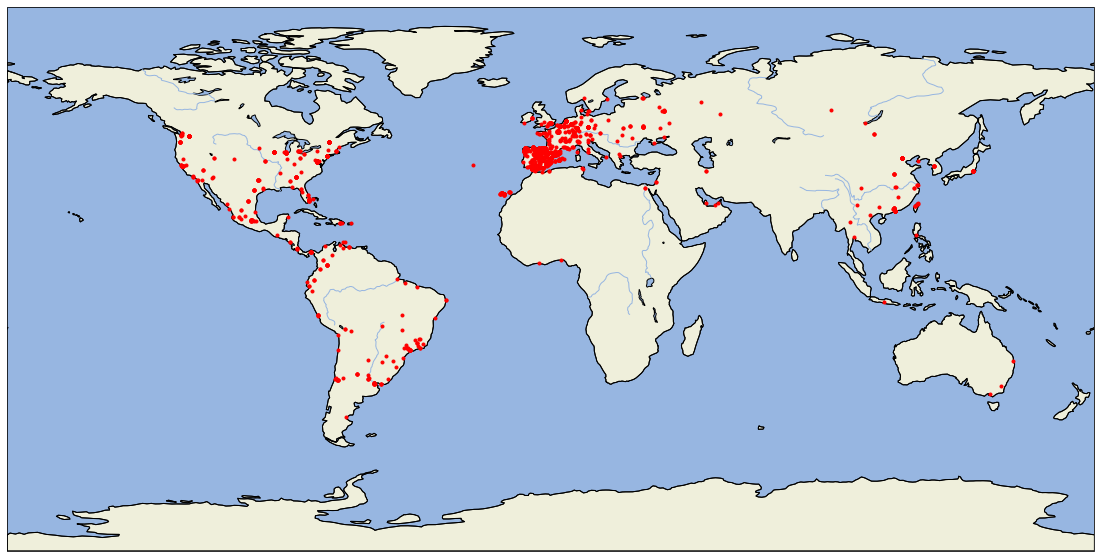

In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_global()

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)

for row in ips_df.itertuples():
    plt.plot(row.lon, row.lat,  markersize=3, marker='o', color='red')

plt.show()

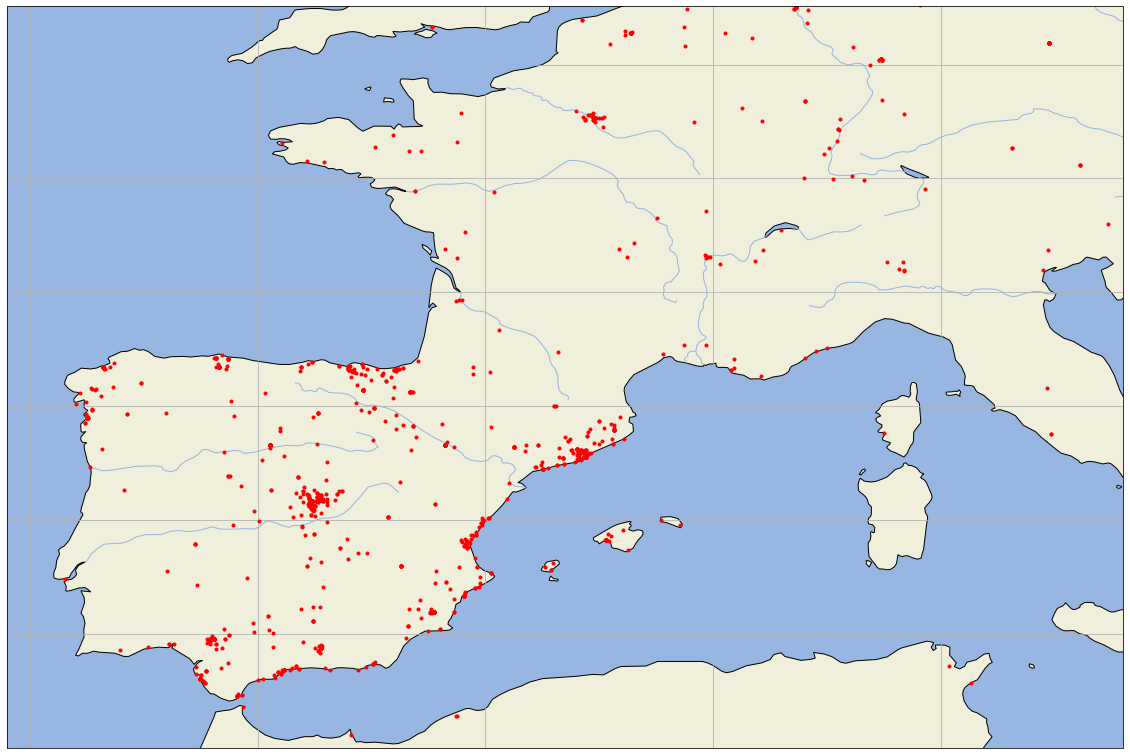

In [39]:
#ampliem a la zona d'europa occidental, on es veuen molt concentrats els punts
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())

extent = (-10.5, 14, 35, 51)
ax.set_extent(extent)

for row in ips_df.itertuples():
    plt.plot(row.lon, row.lat,  markersize=3, marker='o', color='red')

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)
ax.gridlines()

plt.show()

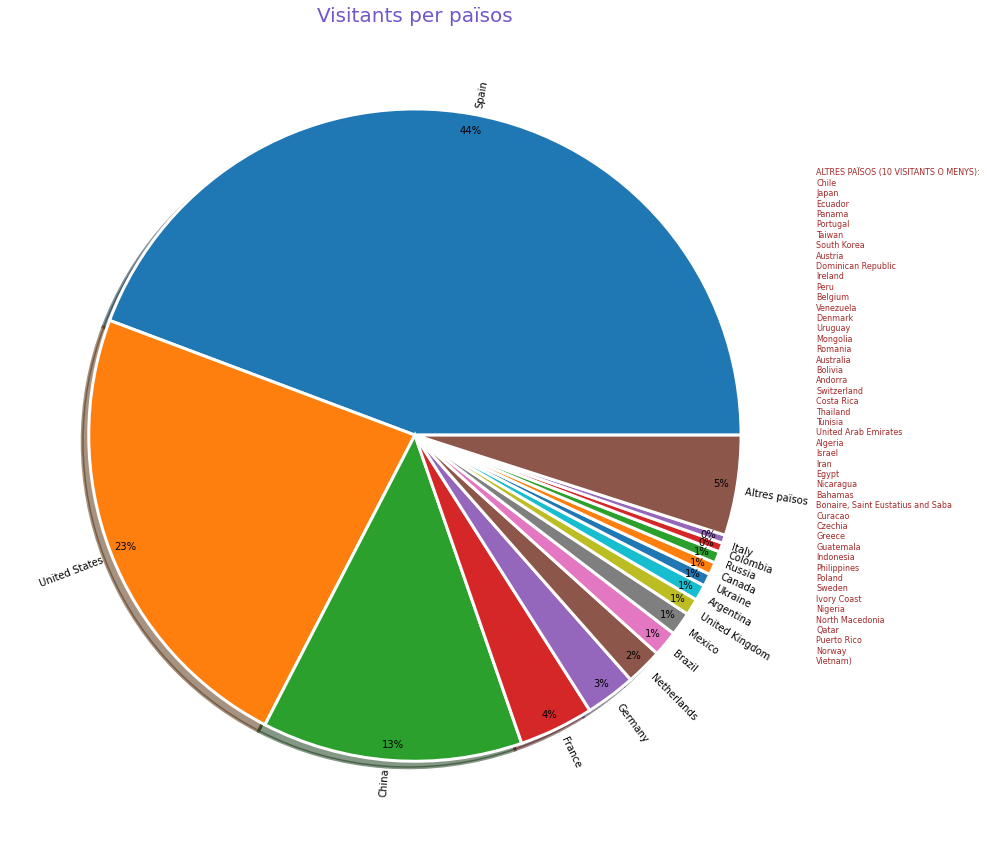

In [40]:
#Per exemple, com estem tractant el tema de la geolocalització, podriem graficar, per països, els porcentatges d'accésos 
#de clients a la web (no contarem la quantitat de clicks que ha donat a la pàgina, és a dir de requests. (Contarem per client)
#com hi han 62 països diferents mostrarem els 15 amb més visitants i els demés els agruparem mostrant els seus noms
clients_x_pais = ips_df.groupby("country")["IP"].count()

#19 països amb més visitants
data = clients_x_pais.sort_values(ascending=False)[:15]

#els altres països
altres_s = clients_x_pais.sort_values(ascending=False)[15:]
paisos = "\n".join(altres_s.index.to_list())
altres_txt = "ALTRES PAÏSOS ({0} VISITANTS O MENYS):\n{1})".format(altres_s.max(), paisos)
altres_s = pd.Series(index=["Altres països"], data=altres_s.sum())

#afegim els països amb menys visitants a les dades a visualitzar
data = data.append(altres_s)
titol = "Visitants per països"

plt.figure(figsize =(15, 15))

plt.pie(data.values, labels=data.index, rotatelabels=True, labeldistance=1.02, 
        wedgeprops = {'linewidth': 3, 'edgecolor': 'w'}, shadow = True, 
        autopct='%1.0f%%', pctdistance=.95, )

plt.title(titol, fontsize=20, color='#6146C6', alpha=0.9, loc="center")
plt.text(1.23,-.7, altres_txt, fontdict={"size":8, "color":"brown"})
plt.show()